In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


ground truth:[0.7657, 0.7702, 0.7703, 0.7701, 0.7766, 0.7795, 0.7769]


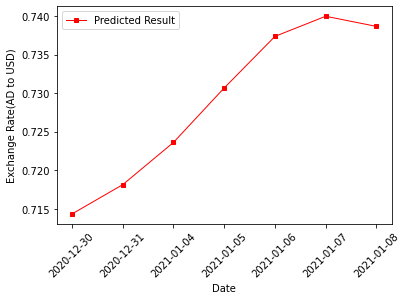

Predicted Value:[0.71431893 0.7181186  0.7235984  0.73066545 0.7373502  0.7399641
 0.738648  ]
MSE：0.0068277264853220734


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
import csv
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time


class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=128,
            num_layers=2, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(128, 1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.out(r_out[:, -7:, :])
        
        return out

def MSE(y, t):
    return 0.5 * np.sum((np.array(y) - np.array(t))**2)

# prediction
def pred(model_name):

    #PATH
    FILE_NAME = model_name
    MODEL_PATH = './gdrive/MyDrive/LSTM_foreign_exchange/train_models/' + FILE_NAME+'_lstm.pkl'

    DAYS_BEFORE=300

    df = pd.read_csv('./gdrive/MyDrive/LSTM_foreign_exchange/data/'+FILE_NAME+'.csv', index_col=0)
    
    df.index = list(map(lambda x:datetime.datetime.strptime(x, '%d-%b-%y'), df.index))
    
    pred_date = []
    for i in df.index[-DAYS_BEFORE : -DAYS_BEFORE + 7].tolist():
      i = str(i)[0:10]
      pred_date.append(i)
    
    series = df['FXRUSD'].copy()
    data = series.tolist()[-DAYS_BEFORE:] # use the last 300 data as input
    lastday_price = data[-1]
    
    ground_truth = data[-DAYS_BEFORE : -DAYS_BEFORE + 7]
    print("ground truth:" + str(ground_truth))
    data_numpy = np.array(data)
    data_mean = np.mean(data_numpy)
    data_std  = np.std(data_numpy)
    data_numpy = (data_numpy - data_mean) / data_std
    data_series = torch.Tensor(data_numpy)

    lstm = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

    x = data_series
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    y = torch.squeeze(lstm(x))

    result = []
    result.append(torch.squeeze(y.cpu()).detach().numpy() * data_std + data_mean)
    result = np.squeeze(result)


    plt.plot(pred_date, result, lw=1, c='red', marker='s', ms=4, label='Predicted Result')
    # plt.plot(pred_date, ground_truth, lw=1, c='g', marker='o', label='Ground Truth')
    # plt-style 
    plt.xticks(rotation=45)
    plt.xlabel('Date')  
    plt.ylabel('Exchange Rate(AD to USD)')  
    plt.legend() 
    plt.savefig('./gdrive/MyDrive/LSTM_foreign_exchange/pred_result_for_show.png')
    plt.show()


    print("Predicted Value:" + str(result))
    print("MSE：" + str(MSE(result, ground_truth)))

pred("exchange_rate")
        
    